Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100
889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - custom_accuracy: 0.2683 - loss: 0.0773
Epoch 1: val_loss improved from inf to 0.01363, saving model to ./models/chat.keras
889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - custom_accuracy: 0.2686 - loss: 0.0773 - val_custom_accuracy: 0.9945 - val_loss: 0.0136
Epoch 2/100
878/889 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - custom_accuracy: 0.9986 - loss: 0.0055
Epoch 2: val_loss improved from 0.01363 to 0.00246, saving model to ./models/chat.keras
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - custom_accuracy: 0.9986 - loss: 0.0055 - val_custom_accuracy: 0.9997 - val_loss: 0.0025
Epoch 3/100
887/889 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - custom_accuracy: 0.9996 - loss: 0.0026
Epoch 3: val_loss improved from 0.00246 to 0.00185, saving model to ./models/chat.keras
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - custom_accuracy: 0.9996 

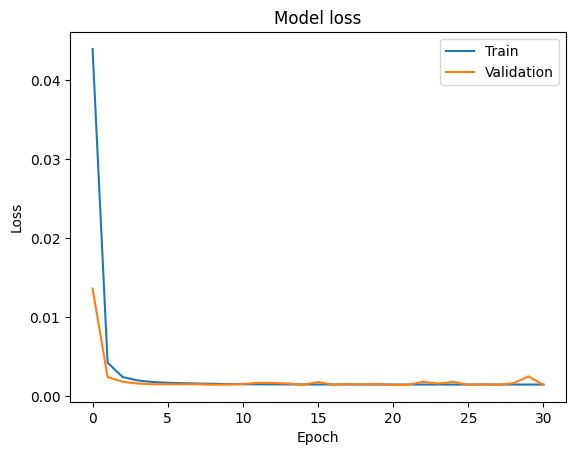

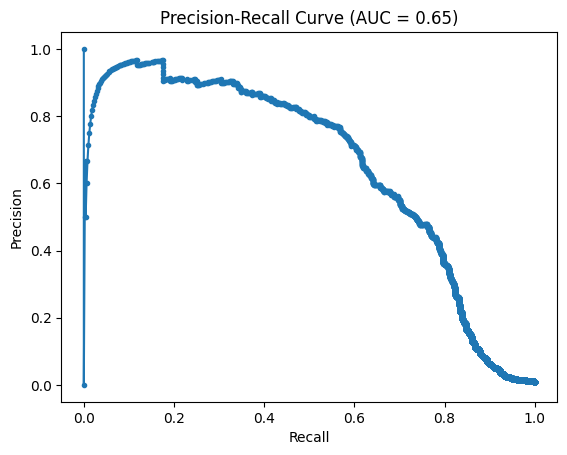

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import l2
from datetime import datetime
import os

from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
df = pd.read_csv('/content/drive/My Drive/creditcard.csv')

# Drop the 'Time' column
df = df.drop(columns=['Time'])

# Normalize all features using MinMaxScaler
scaler = MinMaxScaler()
X = df.drop(columns=['Class'])
X_scaled = scaler.fit_transform(X)

# Separate the target
y = df['Class']

# Separate normal transactions and fraudulent transactions
X_normal = X_scaled[y == 0]
X_fraud = X_scaled[y == 1]

# Split normal transactions into training and validation sets
X_train, X_validate = train_test_split(X_normal, test_size=0.2, random_state=42)

# Combine the validation set (normal) and fraud data for validation/testing
X_test = np.concatenate([X_validate, X_fraud])
y_test = np.concatenate([np.zeros(X_validate.shape[0]), np.ones(X_fraud.shape[0])])

# Define a custom accuracy metric based on reconstruction error
def custom_accuracy(y_true, y_pred):
    error = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    threshold = 0.02
    return tf.reduce_mean(tf.cast(error < threshold, tf.float32))

# Define the autoencoder model with BatchNormalization, L2 regularization, and Dropout
input_dim = X_train.shape[1]
encoding_dim = 14  # Compression factor

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu", kernel_regularizer=l2(0.001))(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)
encoder = Dense(7, activation="relu", kernel_regularizer=l2(0.002))(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)
decoder = Dense(encoding_dim, activation="relu", kernel_regularizer=l2(0.002))(encoder)
decoder = BatchNormalization()(decoder)
decoder = Dropout(0.2)(decoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the model
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mean_squared_error", metrics=[custom_accuracy])

# Callbacks
BATCH_SIZE = 256  # Increased batch size
EPOCHS = 100

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint(filepath=f'./models/chat.keras', verbose=1, save_best_only=True)
log_dir = f'logs/fit/{datetime.now().strftime("%Y%m%d-%H%M%S")}'
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = autoencoder.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_validate, X_validate),
    callbacks=[early_stop, checkpointer, tensorboard_callback]
)

# Evaluate the model on the combined test set
predictions = autoencoder.predict(X_test)

# Calculate the reconstruction error
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_test})

# Dynamically determine the threshold based on the Precision-Recall AUC
precision, recall, thresholds = precision_recall_curve(y_test, mse)
pr_auc = auc(recall, precision)
optimal_idx = np.argmax(precision * recall)  # You can optimize this criterion
threshold = thresholds[optimal_idx]
print(f"Optimal threshold based on PR AUC: {threshold}")

error_df['Predicted_class'] = (error_df['Reconstruction_error'] > threshold).astype(int)

# Confusion matrix and classification report
conf_matrix = confusion_matrix(error_df['True_class'], error_df['Predicted_class'])
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(error_df['True_class'], error_df['Predicted_class'])
print("Classification Report:\n", class_report)

# Calculate and print F1-score, precision, recall, accuracy, and AUC-ROC
y_pred = error_df['Predicted_class']
print("F1-score (micro):", f1_score(error_df['True_class'], y_pred, average='micro'))
print("Precision:", precision_score(error_df['True_class'], y_pred, average='macro'))
print("Recall:", recall_score(error_df['True_class'], y_pred, average='macro'))
print("Accuracy Score:", accuracy_score(error_df['True_class'], y_pred))
print("AUC-ROC Score:", roc_auc_score(error_df['True_class'], mse))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot Precision-Recall Curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.show()


#lhwayj li bdlt : dropout , Batch size , Learning Rate
